In [1]:
%load_ext autoreload
%autoreload 2

import scipy
import numpy as np
import matplotlib.pyplot as plt
import keras
# use torch backend
import torch
from functorch import jacrev, jacfwd



2024-06-19 10:40:54.455675: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 10:40:54.509747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 10:40:54.509777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 10:40:54.510820: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-19 10:40:54.518904: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Distribution Settings
scale = 1
mean = 0

normal_dist = scipy.stats.norm(loc=mean, scale=scale)

# Number of independent datapoints 
T = 1000

seed=360
rng = np.random.RandomState(seed)
y_T = torch.Tensor(normal_dist.rvs(size=T, random_state=rng))

In [14]:
M=100000
param = torch.tensor([1.], requires_grad=True)
param_sized = param*torch.ones(T)
distribution = torch.distributions.Normal(loc=param_sized, scale=1)
samples_MT = distribution.sample(sample_shape=(M,))

In [15]:
samples_MT.shape

torch.Size([100000, 1000])

In [12]:

def get_log_probs(param, samples_MT):
    param_sized = param*torch.ones(T)
    distribution = torch.distributions.Normal(loc=param_sized, scale=1)
    log_probs_MT = distribution.log_prob(samples_MT)

    return log_probs_MT

def get_log_probs_baked(param):
    param_sized = param*torch.ones(T)
    distribution = torch.distributions.Normal(loc=param_sized, scale=1)
    log_probs_MT = distribution.log_prob(samples_MT)

    return log_probs_MT
    

In [172]:
jac = torch.autograd.functional.jacobian(get_log_probs, (param, samples_MT))

In [178]:
# use time magic with 3 runs 
%timeit jac = torch.autograd.functional.jacobian(get_log_probs, (param, samples_MT))

8.13 s ± 159 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [179]:
# use time magic with 3 runs 
%timeit jac = torch.autograd.functional.jacobian(get_log_probs_baked, (param))

6.22 s ± 81.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# use time magic with 3 runs 
%timeit jac = torch.autograd.functional.jacobian(get_log_probs, (param, samples_MT), strategy='forward-mode', vectorize=True)

RuntimeError: [enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 40000000400000000 bytes. Error code 12 (Cannot allocate memory)

In [17]:
# use time magic with 3 runs 
%timeit jac = torch.autograd.functional.jacobian(get_log_probs_baked, (param), strategy='forward-mode', vectorize=True)

2.14 s ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
 jac = torch.autograd.functional.jacobian(get_log_probs_baked, (param), strategy='forward-mode', vectorize=True)

(array([  1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   3.,   1.,
          2.,   8.,   6.,   9.,   7.,   9.,  10.,  24.,  22.,  29.,  21.,
         30.,  33.,  37.,  59.,  54.,  69.,  70.,  72.,  96., 110., 124.,
        156., 156., 183., 184., 233., 193., 225., 245., 224., 265., 290.,
        279., 299., 294., 305., 294., 325., 306., 281., 301., 322., 275.,
        292., 288., 267., 272., 247., 220., 218., 190., 198., 145., 150.,
        119., 134.,  95.,  82.,  80.,  72.,  62.,  50.,  42.,  40.,  27.,
         33.,  20.,  24.,  24.,  11.,  14.,   5.,   9.,   4.,   6.,   5.,
          3.,   1.,   1.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-3.92970634, -3.85055661, -3.77140689, -3.6922574 , -3.61310768,
        -3.53395796, -3.45480824, -3.37565851, -3.29650903, -3.2173593 ,
        -3.13820958, -3.05905986, -2.97991014, -2.90076041, -2.82161093,
        -2.7424612 , -2.66331148, -2.58416176, -2.50501204, -2.42586255,
        -2.34671283, -2.26

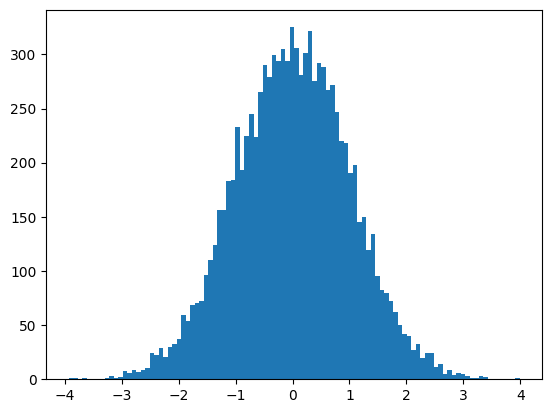

In [147]:
plt.hist(jac[1].flatten().detach().numpy(), bins=100)

In [ ]:

distribution = torch.distributions.Normal(loc=yhat, scale=scale,)

In [129]:
# Create a pytorch layer that just has 1 variable and returns that variable
# this is equivalent to a linear regression model with no features
linear = torch.nn.Linear(0,1, bias=True)

# call linear with a batchsize of 1000
yhat = linear(torch.zeros(1000,0, requires_grad=True))
distribution = torch.distributions.Normal(loc=yhat, scale=scale)

In [130]:
# set linear intercept to 1
linear.bias.data = torch.tensor([1.])

In [117]:
samples_MT = distribution.sample(sample_shape=(M,))
action_samples_MT = distribution.sample(sample_shape=(M,))
action_samples_MT.requires_grad_(True)
expected_action_T = torch.mean(action_samples_MT, dim=0, )
log_probs_MT = distribution.log_prob(samples_MT)

# loss is MSE between y_T and expected action
loss_T = torch.nn.functional.mse_loss(expected_action_T, y_T,)

/tmp/ipykernel_62829/2382041253.py:8: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_T = torch.nn.functional.mse_loss(expected_action_T, y_T,)


In [118]:
jac = torch.autograd.functional.jacobian(get_log_probs, (samples_MT, yhat))

In [124]:
jac[1].shape

torch.Size([10, 1000, 1, 1000, 1])

In [126]:
yhat.shape

torch.Size([1000, 1])